In [18]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from tqdm.auto import tqdm, trange

from nltk.tokenize import word_tokenize

import torch
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
UNK = '<unk>'
PAD = '<pad>'
SOS = '<s>' # start of sentence
EOS = '</s>'

In [3]:
class GloveVocabulary:
    def __init__(self, glove_vocab_path, glove_emb_path):
        self.idx_to_str = [PAD, SOS, EOS] # <unk> is in GloVe
        self.start_idx = len(self.idx_to_str) # length at which real tokens starts
        # load glove into self.idx_to_str and self.str_to_idx
        with open(glove_vocab_path, 'rb') as f:
            glove_vocab = pickle.load(f)
        with open(glove_emb_path, 'rb') as f:
            glove_emb = pickle.load(f)
        self.idx_to_str += glove_vocab
        self.str_to_idx = {s: idx for idx, s in enumerate(self.idx_to_str)}

        # TODO: initialize emb for special tokens
        # instead of random vector, use the mean of all glove vectors for special tokens
        glove_emb = torch.tensor(glove_emb)
        mean_vec = glove_emb.mean(dim=0, keepdim=True)
        self.embedding = torch.cat(
            [mean_vec, mean_vec, mean_vec, glove_emb], dim=0
        )

    def __len__(self):
        return len(self.idx_to_str)

    @staticmethod
    def tokenize(line):
        # TODO: try different tokenizers
        return word_tokenize(line.lower())

    def numericalize(self, line):
        """
        Call this only after the vocab has been built
        """
        tokens = self.tokenize(line)
        ret = [self.str_to_idx[SOS]]
        for token in tokens:
            if token in self.str_to_idx:
                ret.append(self.str_to_idx[token])
            else:
                ret.append(self.str_to_idx[UNK])
        ret.append(self.str_to_idx[EOS])
        return torch.LongTensor(ret)

    def denumericalize(self, token_indices):
        """
        Invert numericalize, returns a string
        """
        # remove start and end token
        ret = []
        for idx in token_indices[1 : -1]:
            token = self.idx_to_str[idx]
            # break early when hitting <pad> token
            if token == PAD:
                break
            else:
                ret.append(token)
        return ' '.join(ret)

In [19]:
def load_file(path, skip_id=False, has_label=True):
    """
    has_label: also return label column if True
    return [['hello world', 'hi'], ['hi World', 'hello']]
    """
    first_lines = []
    second_lines = []
    if has_label:
        labels = []
    if skip_id:
        start_col_idx = 1
    else:
        start_col_idx = 0
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = chunks[start_col_idx]
            second = chunks[start_col_idx + 1]
            first_lines.append(first)
            second_lines.append(second)
            
            if has_label:
                label = int(chunks[start_col_idx + 2])
                labels.append(label)
    if has_label:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines, 
            'is_paraphrase': labels
        })
    else:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines
        })
    return ret

# Model

In [23]:
# %load model.py
import torch
import torch.nn as nn

EMB_DIM = 50

class RNNClassifier(nn.Module):
    def __init__(self, pretrained_emb=None, freeze_emb=False, vocab_size=None, emb_dim=EMB_DIM):
        """
        vocab_size must be not None if no pretrained_emb is given
        """
        super(RNNClassifier, self).__init__()
        if pretrained_emb is None:
            self.emb = nn.Embedding(vocab_size, emb_dim)
            torch.nn.init.uniform_(self.emb.weight, -0.01, 0.01)
        else:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, freeze=freeze_emb)

        rnn_input_dim = self.emb.weight.shape[1] # EMB_DIM
        rnn_output_dim = 128
        # TODO: bidirectional?
        self.rnn = nn.GRU(rnn_input_dim, rnn_output_dim, batch_first=False)

        # pass the concatenation of two RNN outputs to fully connected layers
        fc_input_dim = rnn_output_dim * 2
        fc_hidden_dim = 128
        self.fc1 = nn.Linear(fc_input_dim, fc_hidden_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, 1) # output a scalar for class probability

    def forward(self, x1, x2):
        """
        x1: first sentence, x2: second setences
        (seq_len, batch_size)
        """
        x1 = self.emb(x1)
        x2 = self.emb(x2)
        hidden = None
        for token in x1:
            out1, hidden = self.rnn(token.unsqueeze(0), hidden)
        # TODO: is it better to pass hidden=hidden, hidden=output, or hidden=None
        # can do truncate or pad
        hidden = None
        for token in x2:
            out2, hidden = self.rnn(token.unsqueeze(0), hidden)
        fc_input = torch.cat([out1, out2], dim=-1).squeeze()
        out = F.relu(self.fc1(fc_input))
        # use sigmoid with BCELoss
        out = torch.sigmoid(self.fc2(out))
        return out


In [6]:
def train(model, train_df, dev_df, device, n_epochs=50):
    loss_func = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # record training stats
    best_model = None
    best_dev_accu = 0
    losses = []
    dev_accu_list = []
    
    pbar = tqdm(total=n_epochs * len(train_df), desc='training', leave=True)
    for epoch in range(n_epochs):
        epoch_loss = 0
        for idx in range(len(train_df)):
            pbar.update(1)
            first = train_df.line1_num[idx].unsqueeze(1).to(device)
            second = train_df.line2_num[idx].unsqueeze(1).to(device)
            label = train_df.is_paraphrase[idx]
            label = torch.tensor(label, dtype=torch.float).unsqueeze(0).to(device)

            out = model(first, second)

            optimizer.zero_grad()
            loss = loss_func(out, label)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        # end of epoch, evaluate on dev
        model.eval()
        with torch.no_grad():
            dev_preds = eval(model, dev_df, device)
            dev_accu = accuracy_score(dev_df.is_paraphrase, dev_preds)
        model.train()
        pbar.set_description(
            'Epoch {}: dev_accu: {:4f}, epoch_loss: {:4f}'\
            .format(epoch, dev_accu, epoch_loss))
        pbar.refresh()
        # save model
        if dev_accu > best_dev_accu:
            best_dev_accu = dev_accu
            best_model = deepcopy(model)
            torch.save(best_model.state_dict(), 'output/best_model.pth')
        # record stats
        losses.append(epoch_loss)
        dev_accu_list.append(dev_accu)
    pbar.close()      
    loss_accu_df = pd.DataFrame({
        'epoch': range(1, n_epochs + 1), 
        'loss': losses,
        'dev_accu': dev_accu_list})
    loss_accu_df.to_csv('output/rnn_training.csv', index=False)
    
    return best_model, loss_accu_df

In [7]:
def eval(model, df, device, threshold=0.5):
    """
    threshold: binary probability cutoff
    """
    preds = np.empty(len(df))
    for idx in range(len(df)):
        first = df.line1_num[idx].unsqueeze(1).to(device)
        second = df.line2_num[idx].unsqueeze(1).to(device)
        out = model(first, second)
        preds[idx] = out.item()
        
    preds = np.where(preds > threshold, 1, 0)
    return preds

In [8]:
np.set_printoptions(precision=4)
np.random.seed(0)
torch.manual_seed(0)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Load data
- Concatenate all labeled data: DEV, DEVTEST, DEV-HARD, DEVTEST-HARD
- `train_test_split` twice into `train`, `dev`, `devtest`
- Use `dev` for early stopping
- Evaluate and perform error analysis on `devtest`
- Predict TEST and TEST-HARD

In [10]:
vocab = GloveVocabulary('data/glove_vocab.pkl', 'data/glove_emb.pkl')

In [11]:
dev = load_file('data/dev+devtest/dev.tsv')
dev_hard = load_file('data/heldout-hard/dev.hard.tsv')
devtest = load_file('data/dev+devtest/devtest.tsv')
devtest_hard = load_file('data/heldout-hard/devtest.hard.tsv')
all_df = pd.concat([dev, devtest, dev_hard, devtest_hard])
all_df.reset_index(drop=True, inplace=True)

In [12]:
all_df['line1_num'] = all_df.line1.apply(vocab.numericalize)
all_df['line2_num'] = all_df.line2.apply(vocab.numericalize)

In [13]:
train_df, dev_df = train_test_split(all_df, random_state=0)
dev_df, devtest_df = train_test_split(dev_df, random_state=0)
train_df.reset_index(drop=True, inplace=True)
dev_df.reset_index(drop=True, inplace=True)
devtest_df.reset_index(drop=True, inplace=True)

In [14]:
len(all_df), len(train_df), len(dev_df), len(devtest_df)

(3623, 2717, 679, 227)

In [15]:
train_df.head()

,line1,line2,is_paraphrase,line1_num,line2_num
0,To protect the Savoy. You made a move on The T...,did you take a step on Tumblewee to protect th...,1,"[tensor(1), tensor(7), tensor(1511), tensor(3)...","[tensor(1), tensor(122), tensor(84), tensor(19..."
1,Upstream is the decommissioned Michigan Centra...,Upstream is the decommissioned Michigan Centra...,0,"[tensor(1), tensor(14988), tensor(17), tensor(...","[tensor(1), tensor(14988), tensor(17), tensor(..."
2,"In 1932 , Cuno joined Wilhelm Keppler to advis...",Wilhelm Keppler joined Cuno in 1932 in order t...,0,"[tensor(1), tensor(9), tensor(6188), tensor(4)...","[tensor(1), tensor(11457), tensor(99585), tens..."
3,"I'm so, so sorry.","so far, so.",0,"[tensor(1), tensor(44), tensor(475), tensor(10...","[tensor(1), tensor(103), tensor(375), tensor(4..."
4,I take ship... ransom... nobody get hurt.,I'm nobody.,0,"[tensor(1), tensor(44), tensor(193), tensor(13...","[tensor(1), tensor(44), tensor(475), tensor(32..."


# Build Model and Train

In [25]:
model = RNNClassifier(pretrained_emb=vocab.embedding)
model = model.to(device)

In [26]:
best_model, df = train(model, train_df, dev_df, device)

In [27]:
loaded = RNNClassifier(pretrained_emb=vocab.embedding)
loaded.load_state_dict(torch.load('output/best_model.pth'))
loaded = loaded.to(device)
loaded.eval()

RNNClassifier(
  (emb): Embedding(400004, 50)
  (rnn): GRU(50, 128)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

<AxesSubplot:>

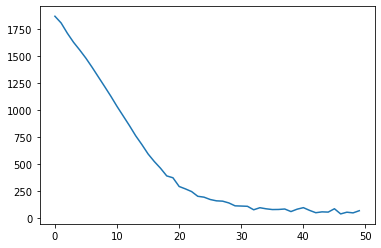

In [28]:
df.loss.plot()

<AxesSubplot:>

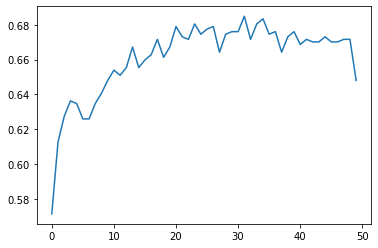

In [29]:
df.dev_accu.plot()

# Error Analysis

In [30]:
preds = eval(loaded, devtest_df, device)
print('devtest accuracy: {:4f}'.format(
    accuracy_score(devtest_df.is_paraphrase, preds)))

devtest accuracy: 0.700441


Text(33.0, 0.5, 'True labels')

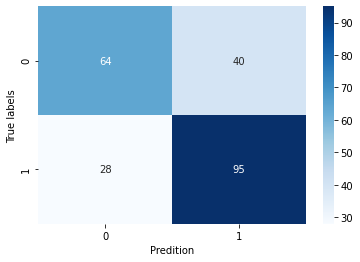

In [31]:
conf_mat = confusion_matrix(devtest_df.is_paraphrase, preds)
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predition')
ax.set_ylabel('True labels')

# Predict

In [32]:
test_df = load_file('data/test_no_labels.tsv', skip_id=True, has_label=False)
test_df['line1_num'] = test_df.line1.apply(vocab.numericalize)
test_df['line2_num'] = test_df.line2.apply(vocab.numericalize)
y_preds = eval(loaded, test_df, device)
submission = pd.DataFrame({
    'id': range(len(y_preds)),
    'Category': y_preds
})

In [33]:
submission.Category.value_counts()

1    2048
0     952
Name: Category, dtype: int64

In [34]:
submission.to_csv('output/submission-rnn.csv', index=False)

In [35]:
test_df = load_file('data/heldout-hard/test.hard.tsv', has_label=False)
test_df['line1_num'] = test_df.line1.apply(vocab.numericalize)
test_df['line2_num'] = test_df.line2.apply(vocab.numericalize)
y_preds = eval(loaded, test_df, device)
submission = pd.DataFrame({
    'id': range(len(y_preds)),
    'Category': y_preds
})

In [36]:
submission.Category.value_counts()

1    1670
0    1330
Name: Category, dtype: int64

In [37]:
submission.to_csv('output/submission-hard-rnn.csv', index=False)